In [3]:
import sqlite3
import pandas as pd

# Connect to SQLite database
DB_FILE = "stock_data.db"
conn = sqlite3.connect(DB_FILE)

# Load data from SQLite
query = "SELECT * FROM stock_kline"
df = pd.read_sql(query, conn)

# Convert date to datetime format
df["date"] = pd.to_datetime(df["date"])

# Close connection
conn.close()

print(df.head())


  stock_code       date  open  high   low  close   volume
0     000001 1991-04-30 -2.22 -2.22 -2.25  -2.25    134.0
1     000001 1991-05-31 -2.14 -2.14 -2.18  -2.18   1887.0
2     000001 1991-06-28 -2.18 -2.18 -2.22  -2.22    306.0
3     000001 1991-07-31 -2.23 -2.23 -2.26  -2.26     61.0
4     000001 1991-08-31 -2.26 -2.26 -2.35  -2.35  32431.0


In [4]:
import numpy as np

def extract_features(stock_df):
    """Extract features from stock's monthly data."""
    if len(stock_df) < 24:  # Require at least 2 years of data
        return None

    stock_df = stock_df.sort_values("date")

    # Compute moving averages
    stock_df["MA5"] = stock_df["close"].rolling(5).mean()
    stock_df["MA20"] = stock_df["close"].rolling(20).mean()

    # Trend features
    trend_12m = (stock_df.iloc[-1]["close"] - stock_df.iloc[-12]["close"]) / stock_df.iloc[-12]["close"] * 100
    ma5_slope = stock_df["MA5"].diff().mean()
    ma20_slope = stock_df["MA20"].diff().mean()
    trend_angle = np.arctan((stock_df["close"].iloc[-1] - stock_df["close"].iloc[-12]) / 12)

    # Volatility features
    price_std_6m = stock_df["close"].iloc[-6:].std()
    price_range_6m = (stock_df["close"].iloc[-6:].max() - stock_df["close"].iloc[-6:].min()) / stock_df["close"].iloc[-6:].min() * 100

    # Compute Bollinger Bands
    stock_df["Bollinger_Upper"] = stock_df["MA20"] + 2 * stock_df["close"].rolling(20).std()
    stock_df["Bollinger_Lower"] = stock_df["MA20"] - 2 * stock_df["close"].rolling(20).std()
    bbw = (stock_df["Bollinger_Upper"].iloc[-1] - stock_df["Bollinger_Lower"].iloc[-1]) / stock_df["MA20"].iloc[-1] * 100

    # K-Line shape features
    positive_candles = np.sum(stock_df["close"].iloc[-6:] > stock_df["open"].iloc[-6:])
    pos_candle_ratio = positive_candles / 6

    # Shadow ratio
    shadow_ratio = np.mean((stock_df["high"].iloc[-6:] - stock_df["low"].iloc[-6:]) / (stock_df["close"].iloc[-6:] - stock_df["open"].iloc[-6:] + 1e-6))

    return [trend_12m, ma5_slope, ma20_slope, trend_angle, price_std_6m, price_range_6m, bbw, pos_candle_ratio, shadow_ratio]


In [5]:
stock_codes = df["stock_code"].unique()
features = []
valid_stocks = []

for stock in stock_codes:
    stock_df = df[df["stock_code"] == stock]
    feature_vector = extract_features(stock_df)
    
    if feature_vector:  # Only append if valid features
        features.append(feature_vector)
        valid_stocks.append(stock)

features = np.array(features)

print(f"Extracted features for {len(valid_stocks)} stocks.")


Extracted features for 4925 stocks.


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


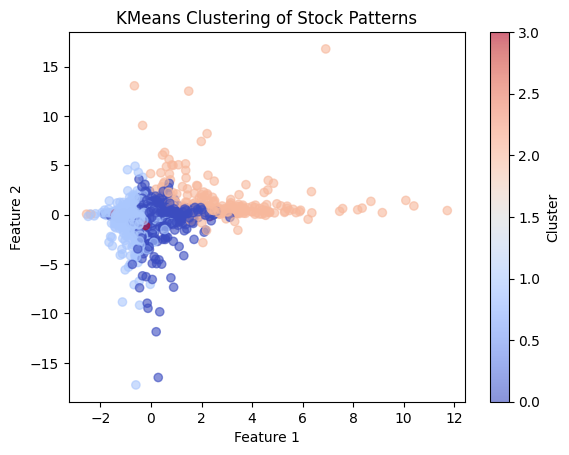

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(features_scaled)

# Visualize Clusters
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=labels, cmap="coolwarm", alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KMeans Clustering of Stock Patterns")
plt.colorbar(label="Cluster")
plt.show()


In [16]:
clustered_stocks = {i: [] for i in range(4)}

for i, stock in enumerate(valid_stocks):
    clustered_stocks[labels[i]].append(stock)

# Print stocks in each cluster
for cluster, stocks in clustered_stocks.items():
    print(f"Cluster {cluster}: {stocks[:10]} ...")  # Show first 10 stocks in each cluster

Cluster 0: ['000006', '000010', '000016', '000021', '000029', '000032', '000034', '000036', '000042', '000050'] ...
Cluster 1: ['000001', '000002', '000004', '000007', '000008', '000009', '000011', '000012', '000014', '000017'] ...
Cluster 2: ['000062', '000096', '000158', '000506', '000520', '000759', '000833', '000880', '001309', '001696'] ...
Cluster 3: ['001207', '001317', '300192', '300236', '300725', '300753', '300991', '301078', '603083', '605186'] ...


In [17]:
cluster_df = pd.DataFrame({"stock_code": valid_stocks, "cluster": labels})
cluster_df.to_csv("stock_clusters.csv", index=False)
print("✅ Clustering results saved to stock_clusters.csv")

✅ Clustering results saved to stock_clusters.csv
